In [1]:
#
# Convolution Neural Network Image classifier
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Load npz data
npz_path = "images/MYIMG/my_img.npz"

load_data = np.load(npz_path)
print ("Load data : " + str(load_data.files))

train_img = load_data['train_img']
train_label = load_data['train_label']
valid_img = load_data['valid_img']
valid_label = load_data['valid_label']
test_img = load_data['test_img']
test_label = load_data['test_label']

print ("train_img shape : "  + str(train_img.shape))
print ("valid_img shape : "  + str(valid_img.shape))
print ("test_img shape : "  + str(test_img.shape))

Load data : ['valid_img', 'train_img', 'test_img', 'train_label', 'test_label', 'valid_label']
train_img shape : (876, 4096)
valid_img shape : (109, 4096)
test_img shape : (111, 4096)


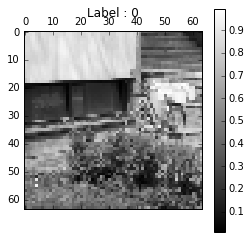

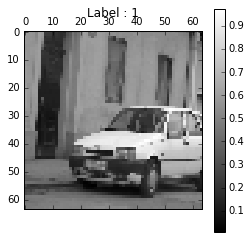

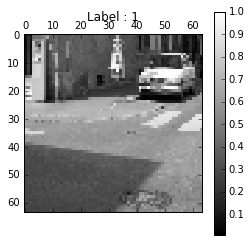

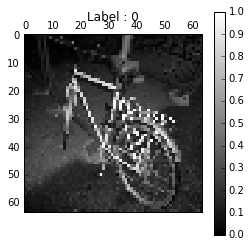

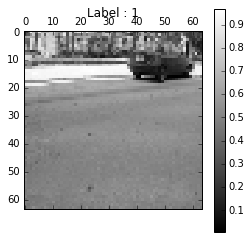

In [3]:
# Plot image
rand_idx = np.arange(train_img.shape[0])
np.random.shuffle(rand_idx)
rand_idx =  rand_idx[:5]

for idx in rand_idx:
    label = np.argmax(train_label[idx])
    img = np.reshape(train_img[idx], (64,64))
    plt.matshow(img,cmap=plt.get_cmap('gray'))
    plt.colorbar()
    plt.title("Label : " + str(label))
    plt.show()

In [4]:
# Options for training
learning_rate = 0.001
training_epochs = 200
batch_size = 100
display_step = 10

# Options for Convolution
x_conv_shape =  [-1,64,64,1] # because MNIST data is oneline

n_conv_shapes = [[7,7,1,128],[3,3,128,128]]
n_conv_strides = [[1,1,1,1],[1,1,1,1]]
n_maxp_shapes = [[1,2,2,1],[1,2,2,1]]
n_maxp_strides = [[1,2,2,1],[1,2,2,1]]

# Options for Dense layer
x_dense_size = 16 * 16 * 128
n_dense = [128]
w_dev = 0.1

# Options for dropout
drop_out_ratio = 0.7

In [5]:
# Build Graph of Convolution Neural Network

# Define placeholder & Variables
x = tf.placeholder("float", [None, train_img.shape[1]])
y = tf.placeholder("float", [None, train_label.shape[1]])
drop_out_prob = tf.placeholder("float")

def one_cnn_layer(_x, _weight_C, _stride_C, _bias_C, _shape_MP, _stride_MP, _dop):
    _conv1 = tf.nn.conv2d(_x, _weight_C, strides=_stride_C, padding='SAME')
    _conv2 = tf.nn.batch_normalization(_conv1, 0.001, 1.0, 0, 1, 0.0001)
    _conv3 = tf.nn.bias_add(_conv2, _bias_C)
    _conv4 = tf.nn.relu(_conv3)
    _pool = tf.nn.max_pool(_conv4, ksize=_shape_MP, strides=_stride_MP, padding='SAME')
    _out = tf.nn.dropout(_pool, _dop)
    return {'conv1':_conv1, 'conv2':_conv2, 'conv3':_conv3, 'conv4':_conv4, 'pool':_pool, 'out':_out}

def one_dense_layer(_x, _W, _b, _dop):
    return tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(_x, _W),_b)), _dop)

WS = {}
BS = {}

last_input_layer = tf.reshape(x, shape = x_conv_shape)
for idx in range(len(n_conv_shapes)):
    _weight_C = tf.Variable(tf.random_normal(n_conv_shapes[idx], stddev=w_dev))
    _stride_C = n_conv_strides[idx]
    _bias_C = tf.Variable(tf.random_normal([n_conv_shapes[idx][-1]], stddev=w_dev))
    _shape_MP = n_maxp_shapes[idx]
    _stride_MP = n_maxp_strides[idx]
    layer = one_cnn_layer(last_input_layer, _weight_C, _stride_C, _bias_C, _shape_MP, _stride_MP, drop_out_prob)
    last_input_layer = layer['out']
    WS['wc_' + str(idx)] = _weight_C
    BS['bc_' + str(idx)] = _bias_C

last_input_layer_size = x_dense_size
last_input_layer = tf.reshape(last_input_layer, [-1, x_dense_size])

for idx, hl_size in enumerate(n_dense):
    _W = tf.Variable(tf.random_normal([last_input_layer_size, hl_size], stddev=w_dev))
    _b = tf.Variable(tf.random_normal([hl_size])) 
    last_input_layer = one_dense_layer(last_input_layer, _W, _b, drop_out_prob)
    last_input_layer_size = hl_size
    WS['wd_' + str(idx)] = _W
    BS['bd_' + str(idx)] = _b

WS['out'] = tf.Variable(tf.random_normal([last_input_layer_size, train_label.shape[1]], stddev=w_dev))
BS['out'] = tf.Variable(tf.random_normal([train_label.shape[1]], stddev=w_dev))

# Define operators
out = tf.add(tf.matmul(last_input_layer, WS['out']), BS['out'])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

pred = tf.argmax(out, 1)
accr = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(y, 1)),"float"))

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


In [6]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_img.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_img.shape[0], size=batch_size)
        batch_xs = train_img[randidx, :]
        batch_ys = train_label[randidx, :]                
            
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        train_img_acc = sess.run(accr , ({x: batch_xs, y: batch_ys, drop_out_prob : 1.}))
        print ("epoch: %03d/%03d  ,  cost: %.6f  ,  train_img_acc: %.3f" \
               % (epoch, training_epochs, avg_cost, train_img_acc))

test_batch_size = 10
avg_acc = 0.
num_batch_test = int(test_img.shape[0]/test_batch_size)
for i in range(num_batch_test):
    batch_xs_test = test_img[i * test_batch_size : (i+1) * test_batch_size ]
    batch_ys_test = test_label[i * test_batch_size : (i+1) * test_batch_size ]            
    avg_acc += sess.run(accr, feed_dict={x : batch_xs_test, y : batch_ys_test, drop_out_prob : 1.})
    
print ("Training complete, Accuracy : %.6f" \
       % (avg_acc / num_batch_test,))

epoch: 000/200  ,  cost: 9.511767  ,  train_img_acc: 0.470
epoch: 010/200  ,  cost: 1.021123  ,  train_img_acc: 0.460
epoch: 020/200  ,  cost: 0.832030  ,  train_img_acc: 0.520
epoch: 030/200  ,  cost: 0.817783  ,  train_img_acc: 0.720
epoch: 040/200  ,  cost: 0.620717  ,  train_img_acc: 0.770
epoch: 050/200  ,  cost: 0.388426  ,  train_img_acc: 0.940
epoch: 060/200  ,  cost: 0.204444  ,  train_img_acc: 0.920
epoch: 070/200  ,  cost: 0.095510  ,  train_img_acc: 1.000
epoch: 080/200  ,  cost: 0.059684  ,  train_img_acc: 1.000
epoch: 090/200  ,  cost: 0.031735  ,  train_img_acc: 1.000
epoch: 100/200  ,  cost: 0.015358  ,  train_img_acc: 1.000
epoch: 110/200  ,  cost: 0.005524  ,  train_img_acc: 1.000
epoch: 120/200  ,  cost: 0.004431  ,  train_img_acc: 1.000
epoch: 130/200  ,  cost: 0.004547  ,  train_img_acc: 1.000
epoch: 140/200  ,  cost: 0.002248  ,  train_img_acc: 1.000
epoch: 150/200  ,  cost: 0.001810  ,  train_img_acc: 1.000
epoch: 160/200  ,  cost: 0.001280  ,  train_img_acc: 1.0